<a href="https://colab.research.google.com/github/GuCastro81/p6a1-visao-computacional/blob/main/train_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Treinamento de Modelo YOLOv5 com visão computacional
O objetivo deste notebook é demonstrar o processo completo de treinamento, validação e teste de um modelo de detecção de objetos utilizando o YOLOv5, integrado ao Google Drive, com imagens.

### 1. Justificativa da escolha das classes

As classes selecionadas para o modelo — `safety_helmet` e `drone` — foram escolhidas com base em critérios de **segurança operacional** e **monitoramento inteligente** do ambiente.

- **`safety_helmet`**: A detecção de capacetes de segurança visa **garantir a integridade física dos colaboradores** em áreas de risco. Essa funcionalidade permite verificar, em tempo real ou em análises posteriores, se os profissionais estão utilizando os EPIs (Equipamentos de Proteção Individual) corretamente, contribuindo para o cumprimento de normas de segurança e redução de acidentes.

- **`drone`**: A detecção de drones tem como objetivo **monitorar a movimentação aérea no entorno da fazenda**, contribuindo para a **segurança patrimonial e vigilância preventiva**. Isso é especialmente relevante em áreas rurais ou de grande extensão, onde o uso de drones pode indicar atividades de inspeção, pulverização, ou até possíveis intrusões.

Essa combinação de classes permite ao modelo atuar como uma ferramenta de suporte à **gestão de segurança física e operacional**, agregando valor tanto na proteção de pessoas quanto na supervisão automatizada do ambiente.


### 2. Métricas utilizadas na avaliação do modelo

Para avaliar o desempenho do modelo de detecção de objetos (YOLOv5), utilizamos um conjunto de métricas padronizadas em visão computacional, que ajudam a medir o quão bem o modelo está conseguindo identificar e localizar os objetos nas imagens.

Utilizamos precisão, recall, MAP0.5, MAP0.9

As métricas de avaliação utilizadas para medir o desempenho do modelo YOLOv5 são fundamentais para entender a qualidade das detecções feitas pelo modelo. A seguir, explicamos o que significa cada métrica, como ela é calculada e qual o valor esperado para considerarmos um bom resultado.

### Precisão (P) — *Precision*

A precisão indica o quanto o modelo acerta quando faz uma detecção. Em outras palavras, mede a quantidade de detecções corretas em relação ao total de detecções realizadas.

Por exemplo: se o modelo detectou 10 objetos e 7 estavam corretos, a precisão é de 70%.

Valores altos de precisão significam que o modelo comete poucos erros ao apontar objetos. De maneira geral:

- Precisão abaixo de 30% → Ruim  
- Precisão entre 30% e 50% → Razoável  
- Precisão acima de 50% → Bom  
- Precisão acima de 70% → Muito bom  
- Precisão acima de 90% → Excelente  



### Recall (R)

O Recall mede a capacidade do modelo de encontrar todos os objetos reais presentes na imagem. Ou seja, representa a quantidade de objetos corretamente detectados em relação ao total de objetos existentes.

Por exemplo: se existiam 10 objetos na imagem e o modelo encontrou 8, o recall é de 80%.

Valores altos de recall indicam que o modelo está localizando a maior parte dos objetos. De modo geral:

- Recall abaixo de 30% → Ruim  
- Recall entre 30% e 50% → Razoável  
- Recall acima de 50% → Bom  
- Recall acima de 70% → Muito bom  
- Recall próximo de 100% → Excelente  



### mAP@0.5
— Mean Average Precision com IoU=0.5

O mAP@0.5 é uma das principais métricas para detecção de objetos. Ele calcula a média da precisão considerando que a sobreposição (*Intersection over Union* — IoU) entre o objeto detectado e o objeto real deve ser de, no mínimo, 50%.

Essa métrica é uma boa referência para entender a capacidade geral do modelo de localizar objetos de forma adequada.

Como referência:

- mAP@0.5 abaixo de 30% → Ruim  
- mAP@0.5 entre 30% e 50% → Aceitável  
- mAP@0.5 entre 50% e 70% → Bom  
- mAP@0.5 acima de 70% → Muito bom  
- mAP@0.5 acima de 90% → Excelente  



### mAP@0.5:0.95
— Mean Average Precision com múltiplos IoU

O mAP@0.5:0.95 é uma métrica mais rigorosa. Ele considera que a deteção está correta quando o posicionamento das caixas predita(bounding boxes) está muito próximo da caixa real(anotada no dataset) avaliando dois níveis de exigência, 50% (IoU ≥ 0.5) e  95% (IoU ≥ 0.9)

Ele indica o quão bom o modelo é não só para encontrar os objetos, mas também para desenhar as caixas de detecção o mais próximo possível da realidade.

De modo geral:

- mAP@0.5:0.95 abaixo de 20% → Fraco  
- mAP@0.5:0.95 entre 20% e 40% → Aceitável  
- mAP@0.5:0.95 entre 40% e 60% → Bom  
- mAP@0.5:0.95 acima de 60% → Excelente  





# 1 Preparação do ambiente e coleta dos dados

Nesta etapa, realizamos a configuração inicial do ambiente e a coleta automatizada de imagens que serão utilizadas no treinamento do modelo de detecção.



## 1.1 Instalação e importação de dependências

Antes de iniciarmos o treinamento do modelo, realizamos a instalação e configuração de alguns recursos essenciais:

- Instalamos a biblioteca `icrawler`e importamos para facilita a coleta e o salvamento automático de imagens da web. Essa etapa é importante para montar nosso dataset de maneira eficiente.

- Também clonamos o repositório do YOLO diretamente no Google Drive. Essa abordagem garante que os arquivos do projeto permaneçam salvos, mesmo em casos de desconexão do Google Colab, evitando perda de progresso durante o desenvolvimento.

In [28]:
%%capture
!pip install icrawler

In [29]:
# Clonando o repositório YOLOv5 para dentro do drive
%%capture
%cd /content/drive/MyDrive/computer_vision/
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

In [20]:
# Biblioteca para baixar imagens
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler, BaiduImageCrawler

# Separação as imagens
import os
import shutil
import random

## 1.2.1 Coleta automatizada de imagens

Para agilizar a construção do dataset utilizado no treinamento do modelo, utilizamos a biblioteca `iCrawler` para realizar a coleta automatizada de imagens diretamente da web, com armazenamento no Google Drive.

Optamos por coletar um número maior de imagens do que o necessário inicialmente, com a intenção de aplicar uma curadoria posterior, eliminando conteúdos irrelevantes, duplicados ou que não atendam aos critérios de qualidade definidos para o projeto.


In [31]:
# Função para buscar e salvar imagens
%%capture
def search_images(nome_objeto, quantidade, caminho_destino):
    google_crawler = GoogleImageCrawler(storage={'root_dir': caminho_destino})
    google_crawler.crawl(keyword=nome_objeto, max_num=quantidade)


path_safety_helmet = "/content/drive/MyDrive/computer_vision/safety_helmet"
path_drone = "/content/drive/MyDrive/computer_vision/drone"

In [ ]:
# buscando imagens de capacete
%%capture
search_images('pessoa com capacete segurança trabalhando', 40, path_safety_helmet)
search_images('capacete de segurança', 40, path_safety_helmet)

In [ ]:
#buscando imagens de drone
%%capture
search_images('drone',150, path_drone)

In [ ]:
search_images('drone fazenda', 150, path_drone)

## 1.2.2. Separação do conjunto de dados

Após a coleta e curadoria das imagens de drone e capacete de segurança, foi realizada a separação do conjunto de dados em três subconjuntos distintos: **treinamento (train)**, **validação (val)** e **teste (test)**. Essa divisão foi aplicada individualmente para cada classe, mantendo as imagens organizadas em subpastas com o nome da classe correspondente.

A separação seguiu os seguintes critérios:

- **4 imagens para validação**  
- **4 imagens para teste**  
- **Demais imagens para treinamento**

Essa estrutura é fundamental para o processo de desenvolvimento do modelo de aprendizado de máquina, permitindo que diferentes etapas do pipeline trabalhem com dados não sobrepostos. A divisão garante:

- **Treinamento**: o modelo aprende padrões a partir das imagens deste conjunto.
- **Validação**: usada durante o treinamento para ajustar hiperparâmetros e evitar overfitting.
- **Teste**: utilizado apenas ao final, para avaliar a capacidade do modelo de generalizar para dados nunca vistos.

A estrutura final do diretório segue o seguinte padrão:

```
dataset/
├── train/
│   ├── drone/
│   └── safety_helmet/
├── val/
│   ├── drone/
│   └── safety_helmet/
├── test/
│   ├── drone/
│   └── safety_helmet/
```


A separação foi feita de forma automatizada com um script Python que embaralha as imagens antes da divisão, garantindo uma distribuição aleatória dos dados, o que reduz possíveis vieses e melhora a robustez do modelo durante o treinamento e validação.


In [ ]:
# Função para separar as imagens
def split_dataset(source_dir, target_base_dir, n_test=4, n_val=4):
    class_name = os.path.basename(source_dir)
    train_dir = os.path.join(target_base_dir, 'train', class_name)
    test_dir = os.path.join(target_base_dir, 'test', class_name)
    val_dir = os.path.join(target_base_dir, 'val', class_name)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    images = os.listdir(source_dir)
    random.shuffle(images)

    test_images = images[:n_test]
    val_images = images[n_test:n_test + n_val]
    train_images = images[n_test + n_val:]

    for img in test_images:
        shutil.copy(os.path.join(source_dir, img), os.path.join(test_dir, img))

    for img in train_images:
        shutil.copy(os.path.join(source_dir, img), os.path.join(train_dir, img))

    for img in val_images:
        shutil.copy(os.path.join(source_dir, img), os.path.join(train_dir, img))

In [ ]:
# Separando as imagens
output_path = "/content/drive/MyDrive/computer_vision/dataset"
split_dataset(path_safety_helmet, output_path, n_test=4, n_val=4)
split_dataset(path_drone, output_path, n_test=4, n_val=4)

## 1.3 Gerando arquivo yaml

O arquivo `custom.yaml` é necessário para configurar o treinamento do YOLO com dados personalizados. Ele informa ao modelo:

- Os caminhos para os conjuntos de treino, validação e teste.
- Os nomes e a quantidade de classes do dataset.

Esse arquivo é passado como argumento (`--data`) durante o treinamento e garante que o modelo utilize os dados corretos e aprenda as classes definidas pelo usuário.

A anotação das imagens foram feitas utilizando a ferramenta [MakeSense.ai](https://www.makesense.ai/), que gera os arquivos no formato compatível com o YOLO.

No caso deste projeto, as classes foram definidas como:
- `0`: safety_helmet
- `1`: drone




In [1]:
# Caminhos para as imagens e anotações

%cd /content/drive/MyDrive/computer_vision/
dataset_path = "/content/drive/MyDrive/computer_vision/dataset/images"


# Criando arquivo de configuração para o dataset
config_yaml = f"""
train: {dataset_path}/train
val: {dataset_path}/val
test: {dataset_path}/test

# Classes
names:
  0: safety_helmet
  1: drone
"""
with open("custom.yaml", "w") as f:
    f.write(config_yaml)

# # Criando estrutura esperada do YOLO
# !mkdir -p {dataset_path}/images/train
# !mkdir -p {dataset_path}/images/val
# !mkdir -p {dataset_path}/images/test
# !mkdir -p {dataset_path}/labels/train
# !mkdir -p {dataset_path}/labels/val
# !mkdir -p {dataset_path}/labels/test


/content/drive/MyDrive/computer_vision


# 2. Fase de treinamento e validação

Treinando e validando os modelos com 30 e 60 épocas


## Análise técnica dos resultados do modelo de 30 epocas (Validação)

### Resumo do modelo
- **Total de Camadas**: 157  
- **Parâmetros**: 7.015.519  
- **Gradientes**: 0 (modo de avaliação)  
- **GFLOPs**: 15.8  

---

### Desempenho geral

| Métrica           | Valor   |
|-------------------|---------|
| **Precisão (P)**  | 0.534   |
| **Revocação (R)** | 0.625   |
| **mAP@0.5**       | 0.627   |
| **mAP@0.5:0.95**  | 0.317   |

> O desempenho geral do modelo é modesto, com uma mAP@0.5 de **62.7%**, o que sugere que ele possui alguma capacidade de detectar objetos corretamente em termos de localização.  
> No entanto, o mAP@0.5:0.95 de **31.7%** indica dificuldade do modelo em manter precisão sob limiares de IoU mais rigorosos.

---

### Desempenho por classe

#### 🟡 `safety_helmet`
- **Precisão**: 0.467  
- **Revocação**: 0.25  
- **mAP@0.5**: 0.259  
- **mAP@0.5:0.95**: 0.102  

**Análise:**  
A performance para a classe `safety_helmet` é significativamente baixa. A revocação de apenas 25% evidencia que o modelo está deixando passar a maior parte dos capacetes presentes nas imagens.  
Além disso, os valores de mAP refletem baixa confiabilidade na detecção, mesmo com sobreposição permissiva.

---

#### 🔵 `drone`
- **Precisão**: 0.601  
- **Revocação**: 1.0  
- **mAP@0.5**: 0.995  
- **mAP@0.5:0.95**: 0.531  

**Análise:**  
A classe `drone` apresenta excelente desempenho. A revocação perfeita (1.0) e o altíssimo mAP@0.5 (~99.5%) indicam que o modelo detecta praticamente todos os drones de forma precisa.  
Mesmo sob limiares mais rigorosos, o mAP@0.5:0.95 de **53.1%** mostra uma boa capacidade de generalização.

---

### Conclusão técnica

O modelo mostra **resultados muito bons para a classe `drone`**, mas **desempenho insatisfatório para `safety_helmet`**. A grande disparidade sugere que há **desequilíbrio no aprendizado por classe**, possivelmente devido a:
- Poucas amostras representativas de capacetes,
- Diversidade limitada nas imagens dessa classe,
- Anotações imprecisas ou inconsistentes.

---

###  Recomendação

- O modelo **não é adequado para produção no estado atual**, especialmente se a detecção de capacetes for um requisito crítico.
- Para melhorar a performance geral:
  - **Aumentar a quantidade e a variedade de imagens com capacetes**,
  - Aplicar *data augmentation* focado na classe `safety_helmet`,
  - Verificar qualidade das anotações e balancear as classes no treinamento.




In [3]:
## Modelo com 30 épocas
!python yolov5/train.py --data custom.yaml --weights yolov5s.pt --img 640 --epochs 30


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-04-18 15:36:33.892480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744990593.965810    5526 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744990593.987680    5526 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&

In [ ]:
%cd /content/drive/MyDrive/computer_vision/
!python yolov5/train.py --data custom.yaml --weights yolov5s.pt --img 640 --epochs 60

/content/drive/MyDrive/computer_vision
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvid

## Análise técnica dos resultados de 60 epocas

### Resumo do Modelo
- **Arquitetura**: 157 camadas  
- **Parâmetros**: ~7 milhões  
- **GFLOPs**: 15.8  
- **Gradientes**: 0 (modo de avaliação)  
- **Tempo por epoch**: ~3 segundos  
- **Resultados salvos em**: `yolov5/runs/train/exp2`

---

###  Desempenho geral

| Métrica           | Valor   |
|-------------------|---------|
| **Precisão (P)**  | 0.62    |
| **Revocação (R)** | 0.726   |
| **mAP@0.5**       | 0.675   |
| **mAP@0.5:0.95**  | 0.494   |

> O modelo apresenta desempenho razoável considerando o tamanho reduzido do conjunto de validação (**apenas 8 imagens e 7 instâncias**).  
> A **mAP@0.5 de 67.5%** indica uma capacidade decente de detectar objetos com boa sobreposição, e a **mAP@0.5:0.95 de 49.4%** mostra um desempenho mais modesto em diferentes limiares de IoU.

---

###  Desempenho por classe

#### 🟡 Capacete de segurança - `safety_helmet`
- **Precisão**: 0.635  
- **Revocação**: 0.452  
- **mAP@0.5**: 0.52  
- **mAP@0.5:0.95**: 0.318  

**Análise:**  
A classe `safety_helmet` tem uma precisão moderada, mas a revocação está relativamente baixa (45.2%), indicando que o modelo está deixando de detectar alguns capacetes de segurança.  
O mAP@0.5:0.95 é o mais baixo entre as classes, sugerindo sensibilidade à variação de posição, tamanho ou forma.

---

#### 🔵 Drone - `drone`
- **Precisão**: 0.605  
- **Revocação**: 1.0  
- **mAP@0.5**: 0.83  
- **mAP@0.5:0.95**: 0.67  

**Análise:**  
O desempenho para a classe `drone` é significativamente melhor. A revocação perfeita (1.0) indica que todos os drones foram detectados, e os valores elevados de mAP indicam boa generalização mesmo com variações espaciais.  
Apesar da precisão não ser máxima, o equilíbrio com a revocação garante qualidade nos resultados.

---

### Conclusão Técnica

Apesar da amostra ser bastante limitada (apenas 8 imagens e 7 instâncias), o modelo apresenta **desempenho promissor**, especialmente para a classe `drone`.

A classe `safety_helmet`, por outro lado, requer **atenção e melhorias**. Os resultados sugerem que o modelo precisa de:
- Mais dados de treinamento,
- Aumento da diversidade nas amostras,
- Melhor refinamento das anotações.

---

### Recomendação

- O modelo **pode ser utilizado em ambiente de testes controlado** ou como base para iteração.
- Para uso em produção:
  - **Expandir o conjunto de dados**
  - Ajustar hiperparâmetros
  - Aplicar *data augmentation* focado nos capacetes
- Avaliar o modelo em um conjunto de validação mais robusto é **essencial** para garantir sua confiabilidade.


# 3. Fase de teste

Testando modelos de 30 e 60 épocas



## Avaliação dos resultados de teste de 30 epocas

### 🟡 Detecção de Capacetes de Segurança - `safety_helmet`
Durante a fase de testes, foi possível observar limitações importantes no desempenho do modelo pricipalemnte para essa classe.

Das quatro imagens utilizadas para testar essa classe:
- Apenas **duas** foram corretamente identificadas;
- Uma imagem estava no formato `.webp`, o que impossibilitou sua visualização no Colab;
- Apenas **uma** imagem teve uma detecção com confiança superior a 0.40 (especificamente 0.44);
- As demais imagens não geraram bounding boxes.

Uma possível explicação observada é que, na maioria das imagens do conjunto de treinamento, os indivíduos que utilizam capacetes de segurança também estão usando protetores auriculares. Como resultado, o modelo parece ter aprendido a associar a presença do capacete **junto aos fones de ouvido**, dificultando a generalização para casos onde apenas o capacete aparece.

### 🔵Detecção de Drones - `drone`
No caso da classe **drone**, o desempenho foi um pouco superior:
- Das três imagens testadas, **duas** foram corretamente detectadas;
- As detecções ocorreram com **confianças de 0.39 e 0.50**, respectivamente.

A limitação nesse caso pode estar relacionada à **variedade de modelos de drones** presentes nas imagens e à **falta de amostras com diferentes ângulos de visão** no treinamento. Como drones têm formatos bastante variados, o modelo pode não ter conseguido aprender representações suficientemente robustas.



### Considerações finais sobre o modelo

Os resultados indicam que o modelo ainda está com **baixa capacidade de generalização**, especialmente para a classe de capacetes. Isso reforça a importância de:
Os resultados indicam que o modelo ainda apresenta baixa capacidade de generalização, especialmente para a classe de capacetes. Isso reforça a importância de:

- Aumentar a **diversidade das imagens de treinamento**, especialmente variando os contextos (com e sem protetores auriculares);
- Incluir **mais exemplos de diferentes modelos de drones**, capturados de múltiplos ângulos e em diferentes condições de iluminação;
- Aplicar **técnicas de data augmentation** para ampliar a variabilidade dos dados e melhorar a robustez do modelo.


Isso tudo pode causar um “desequilíbrio semântico”, ou seja, o modelo aprende a reconhecer apenas certos padrões recorrentes, e ignora variações reais que deveriam ser aprendidas.



In [8]:
# @title
# Teste com o modelo de 30 épocas
!python yolov5/detect.py --weights yolov5/runs/train/exp/weights/best.pt --source {dataset_path}/test --name resultado_30epocas


detect: weights=['yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/computer_vision/dataset/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=resultado_30epocas, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /content/drive/MyDrive/computer_vision/dataset/images/test/00001.jpg: 448x640 1 drone, 295.2ms
image 2/8 /content/drive/MyDrive/computer_vision/dataset/images/test/00002.webp: 448x640 1 drone, 410.7ms
image 3/8 /content/drive/MyDrive/computer_vision/dat

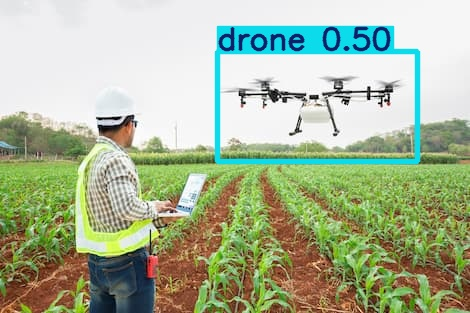

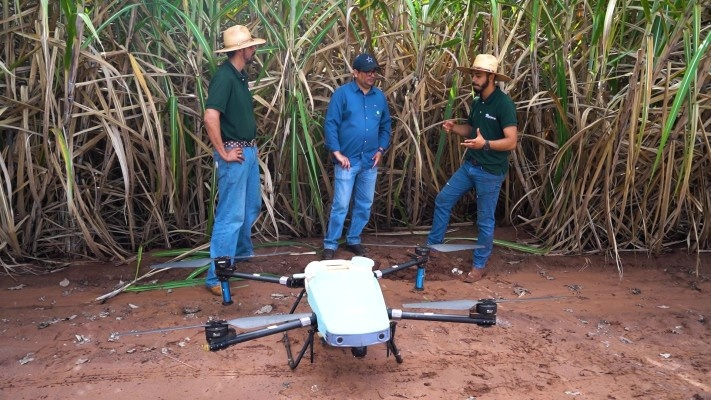

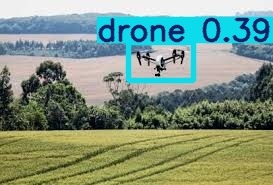

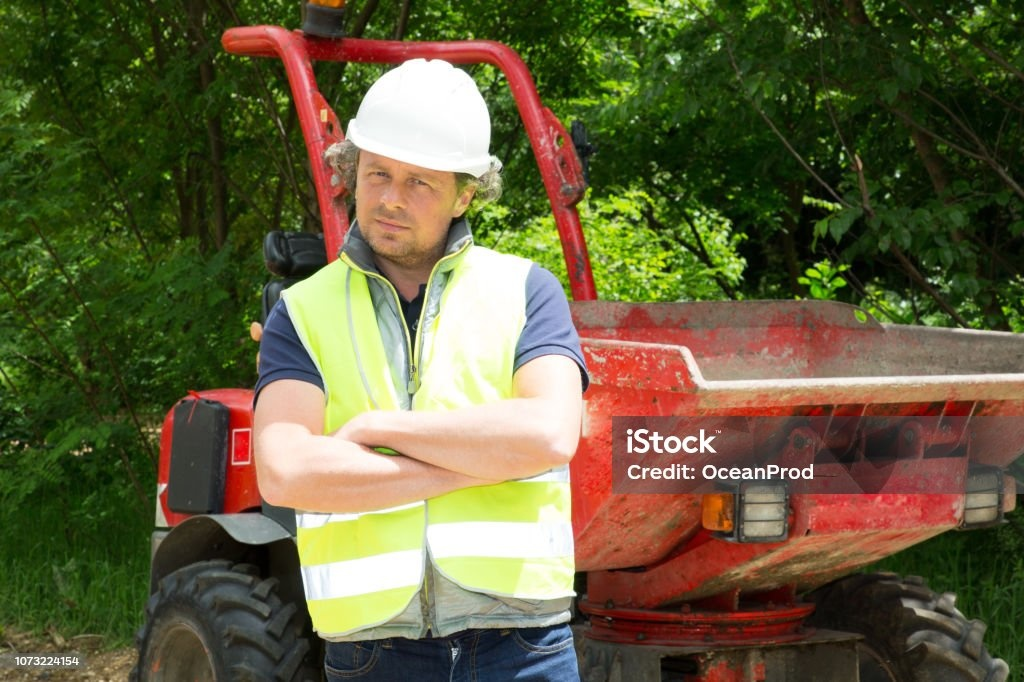

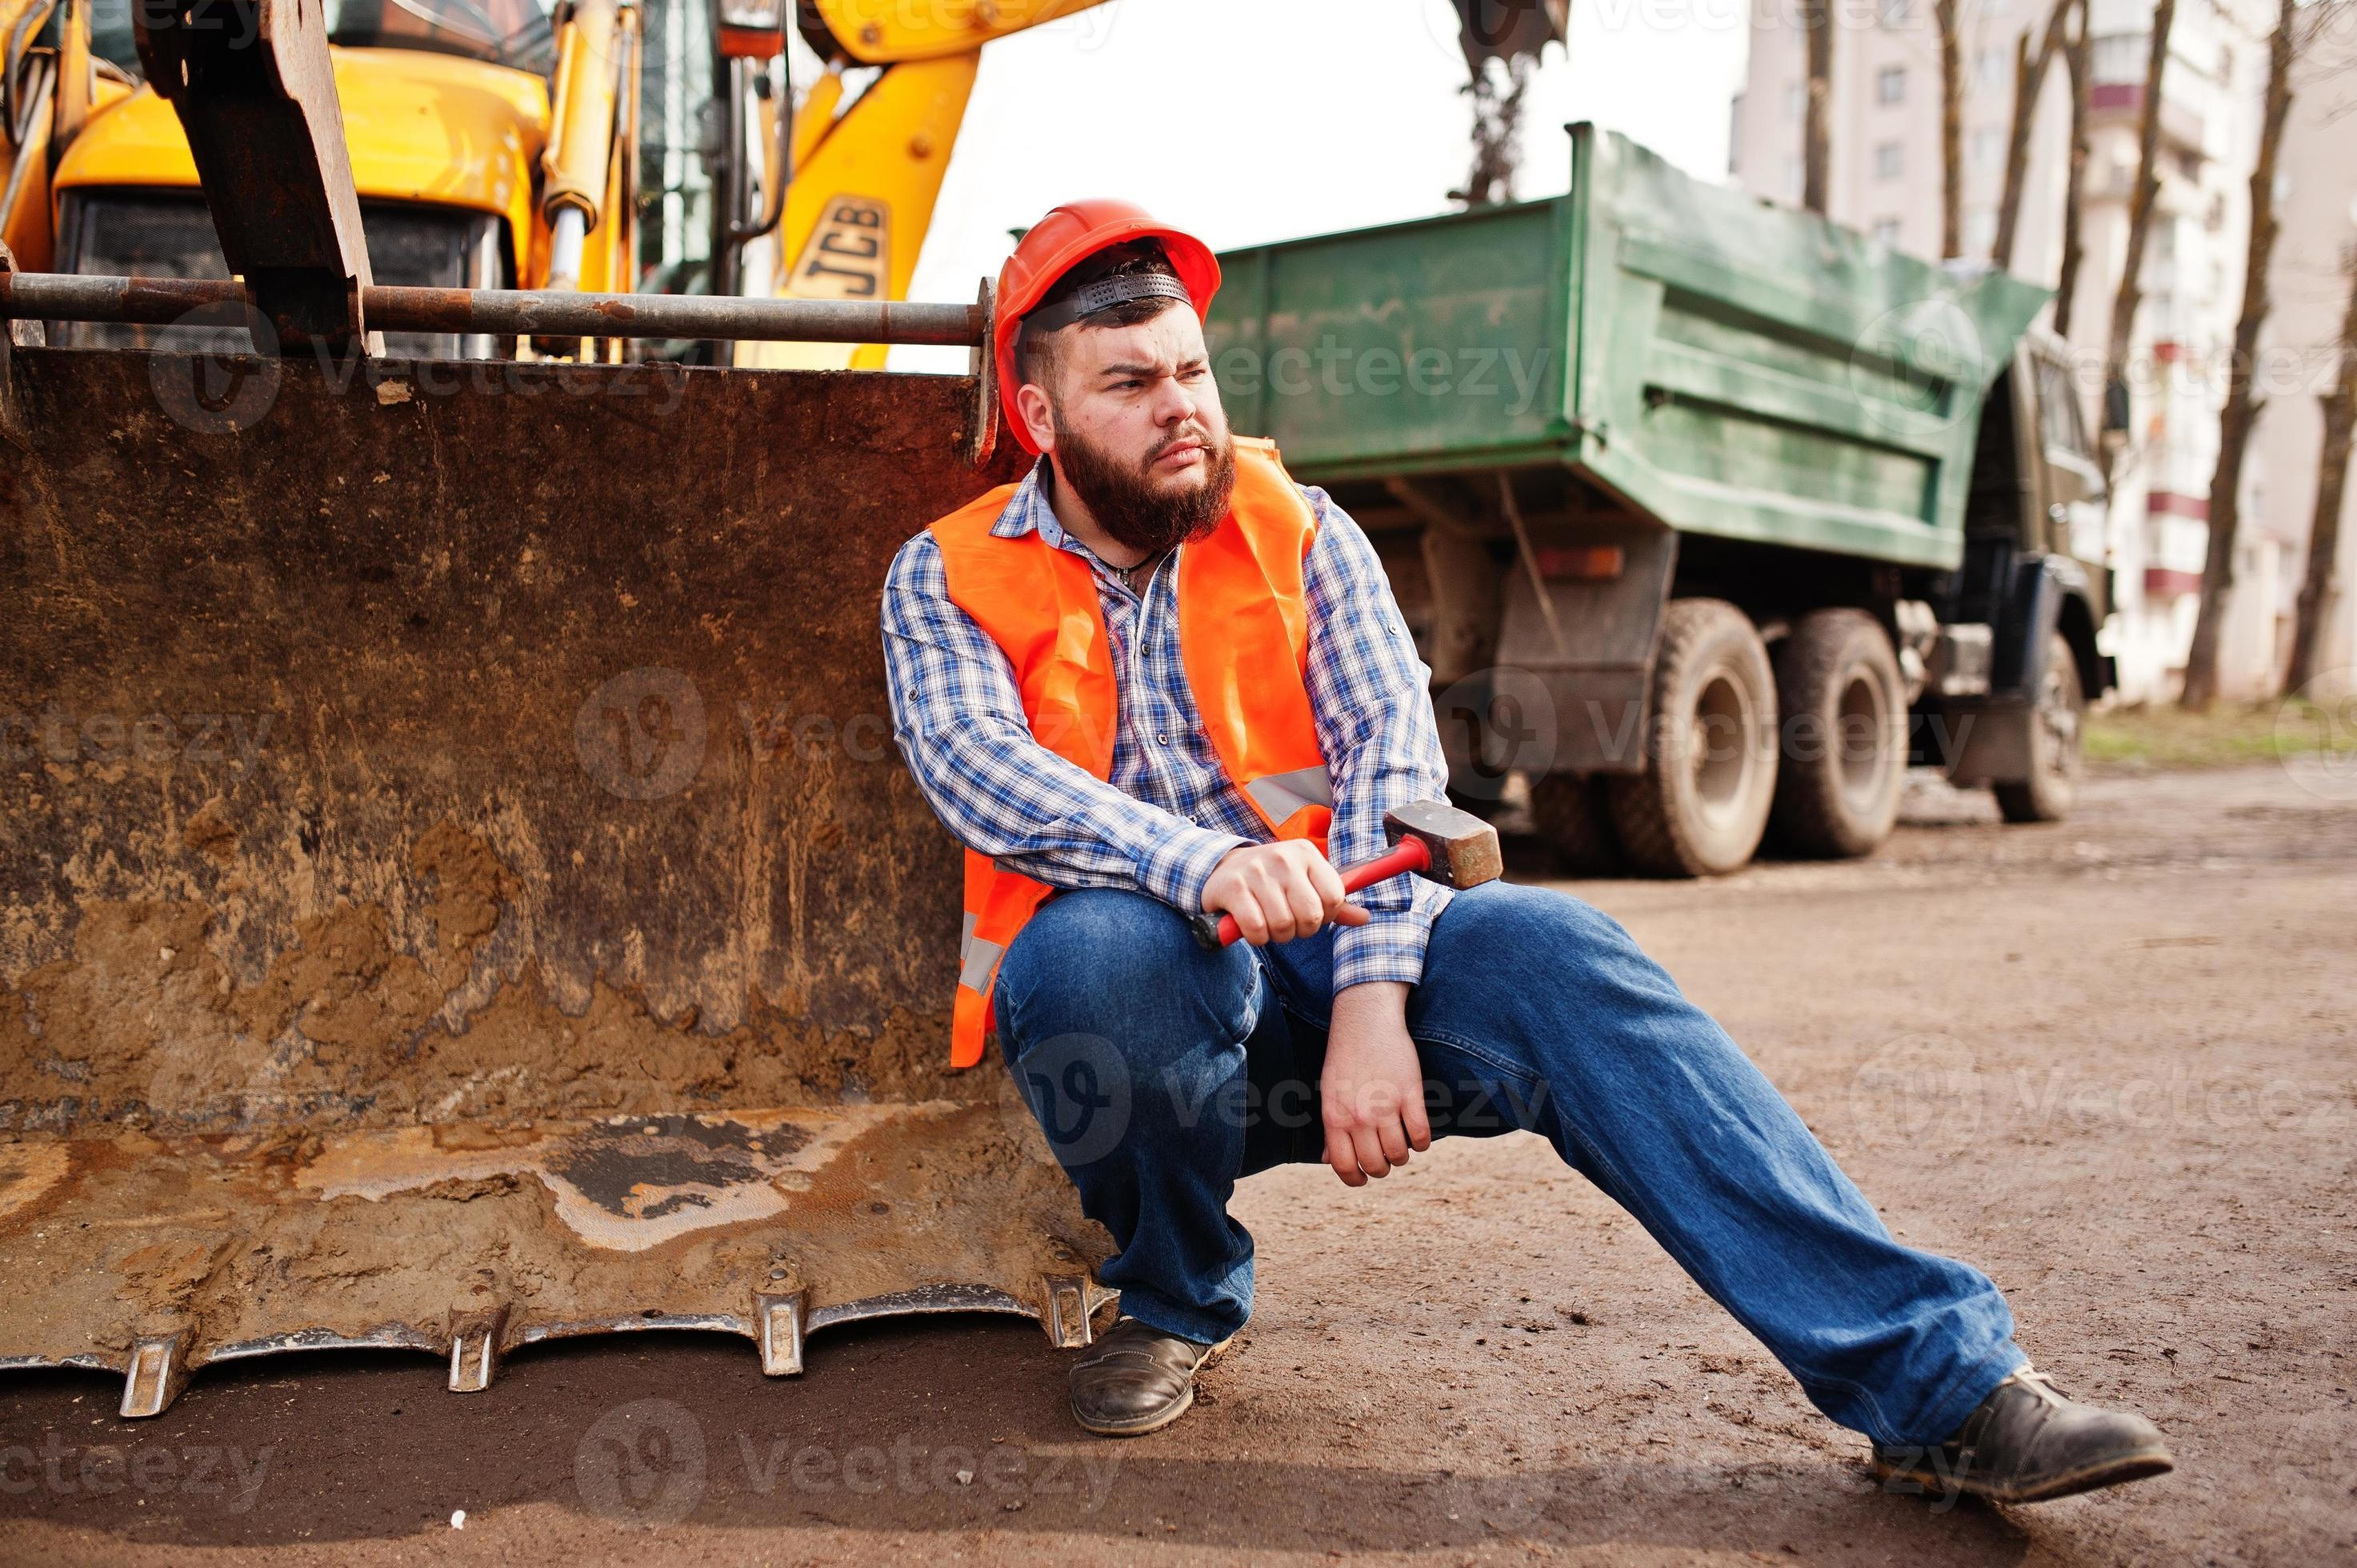

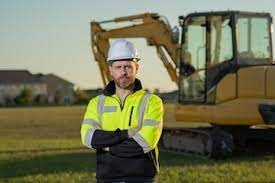

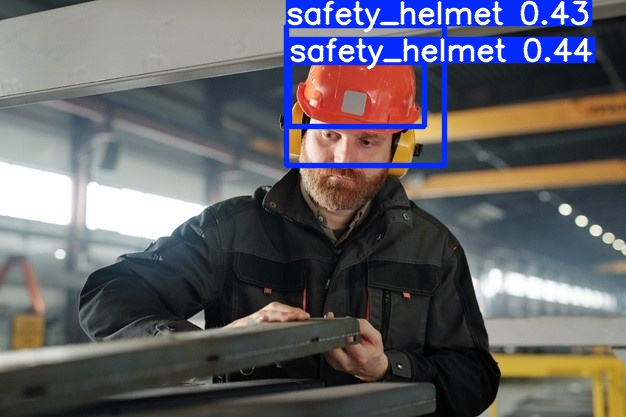

In [18]:
# @title

import glob
from IPython.display import Image, display

image_paths = glob.glob('yolov5/runs/detect/resultado_30epocas2/*.jpg')

for path in image_paths:
    display(Image(filename=path))


## Avaliação dos resultados com modelo treinado (60 épocas)

Com o modelo treinado por 60 épocas, foi possível observar uma melhora significativa na detecção dos objetos, especialmente na classe `safety_helmet`.

### 🟡 Detecção de Capacetes de Segurança - `safety_helmet`

Das quatro imagens utilizadas para teste:

- **Três capacetes foram corretamente detectados**, com confiabilidades de:
  - **0.64** — imagem com capacete e protetor auricular (padrão dominante no dataset);
  - **0.46** e **0.43** — em diferentes condições de iluminação e ângulo.

A única imagem não detectada apresentava o capacete posicionado de forma mais despojada, com parte do cabelo do usuário visível. Embora a detecção tenha falhado, esse caso pode ser interpretado como positivo, uma vez que o **uso inadequado do EPI não foi reconhecido como válido pelo modelo**, o que está alinhado com a proposta de identificar situações de risco.

Além disso, a análise reforça a observação de que o modelo aprendeu a associar **capacetes ao uso simultâneo de protetores auriculares**, provavelmente pela predominância desse padrão nas imagens de treinamento. Isso sugere uma necessidade de **ampliar a diversidade das imagens**, incluindo exemplos variados de uso correto do EPI, com e sem acessórios adicionais.

### 🔵  Detecção de Drones - `drone`

Nas três imagens avaliadas:

- **Duas apresentavam drones em voo**, ambas detectadas com alta confiabilidade (**0.73** e **0.76**);
- A terceira imagem, com um drone pousado, **não foi detectada**.

Essa limitação pode, na verdade, ser **benéfica no contexto do projeto**, pois o objetivo principal é identificar **ameaças em tempo real**, como drones voando em áreas restritas. Drones pousados ou inativos não configuram risco imediato, e a não detecção desses pode até **reduzir falsos positivos** relacionados a drones operados pela própria equipe.



## Conclusão final sobre o projeto

Os resultados obtidos nesta versão preliminar do modelo indicam um desempenho **satisfatório para um estágio de prova de conceito (POC)**.

- A classe `drone` apresentou excelente desempenho em condições alinhadas com o objetivo do sistema.
- A classe `safety_helmet` mostrou boa capacidade de detecção, mas ainda requer **maior variedade nos exemplos de treinamento** para garantir robustez em situações reais.

Recomenda-se, para as próximas etapas:
- Reforçar o treinamento com novas imagens em diferentes contextos;
- Diversificar ângulos, iluminações e variações do objeto;
- Realizar testes controlados em campo, simulando situações reais de operação.

Com esses ajustes, o modelo pode se tornar um **importante recurso para aumentar a segurança em ambientes monitorados**, auxiliando na identificação de riscos e violações de protocolos de forma automatizada.


In [9]:
# @title
# Teste com o modelo de 60 épocas
!python yolov5/detect.py --weights yolov5/runs/train/exp2/weights/best.pt --source {dataset_path}/test --name resultado_60epocas

detect: weights=['yolov5/runs/train/exp2/weights/best.pt'], source=/content/drive/MyDrive/computer_vision/dataset/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=resultado_60epocas, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /content/drive/MyDrive/computer_vision/dataset/images/test/00001.jpg: 448x640 1 drone, 298.0ms
image 2/8 /content/drive/MyDrive/computer_vision/dataset/images/test/00002.webp: 448x640 1 drone, 264.9ms
image 3/8 /content/drive/MyDrive/computer_vision/da

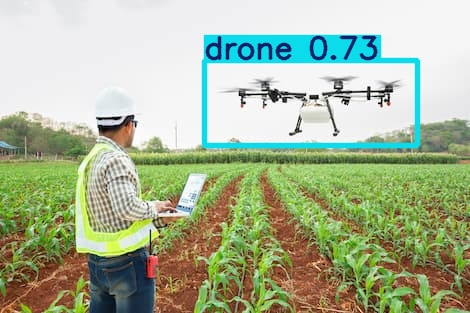

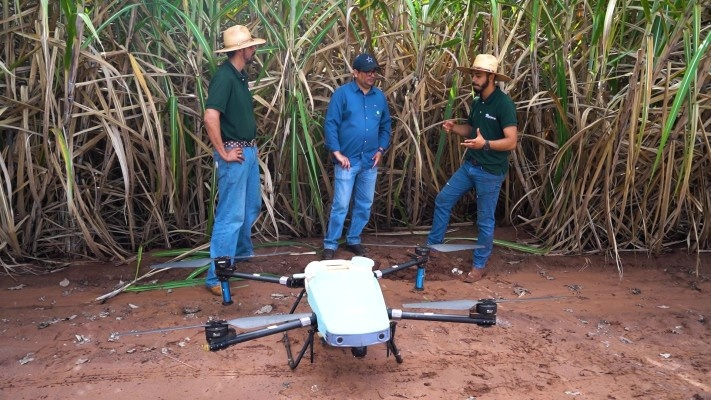

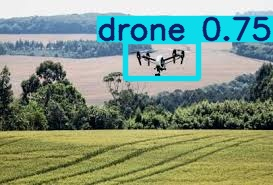

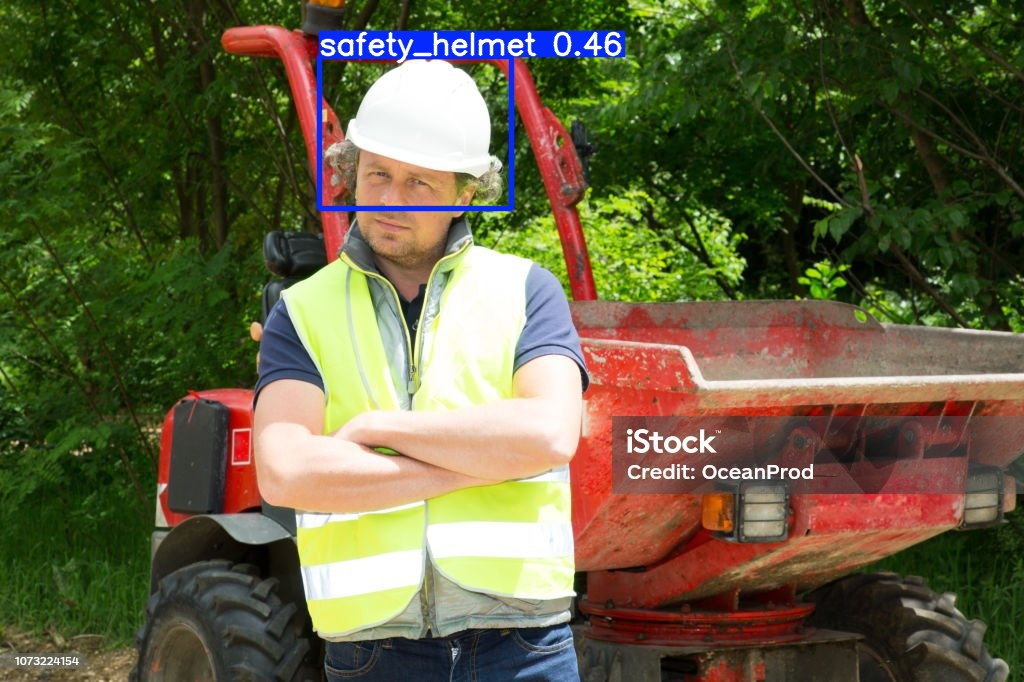

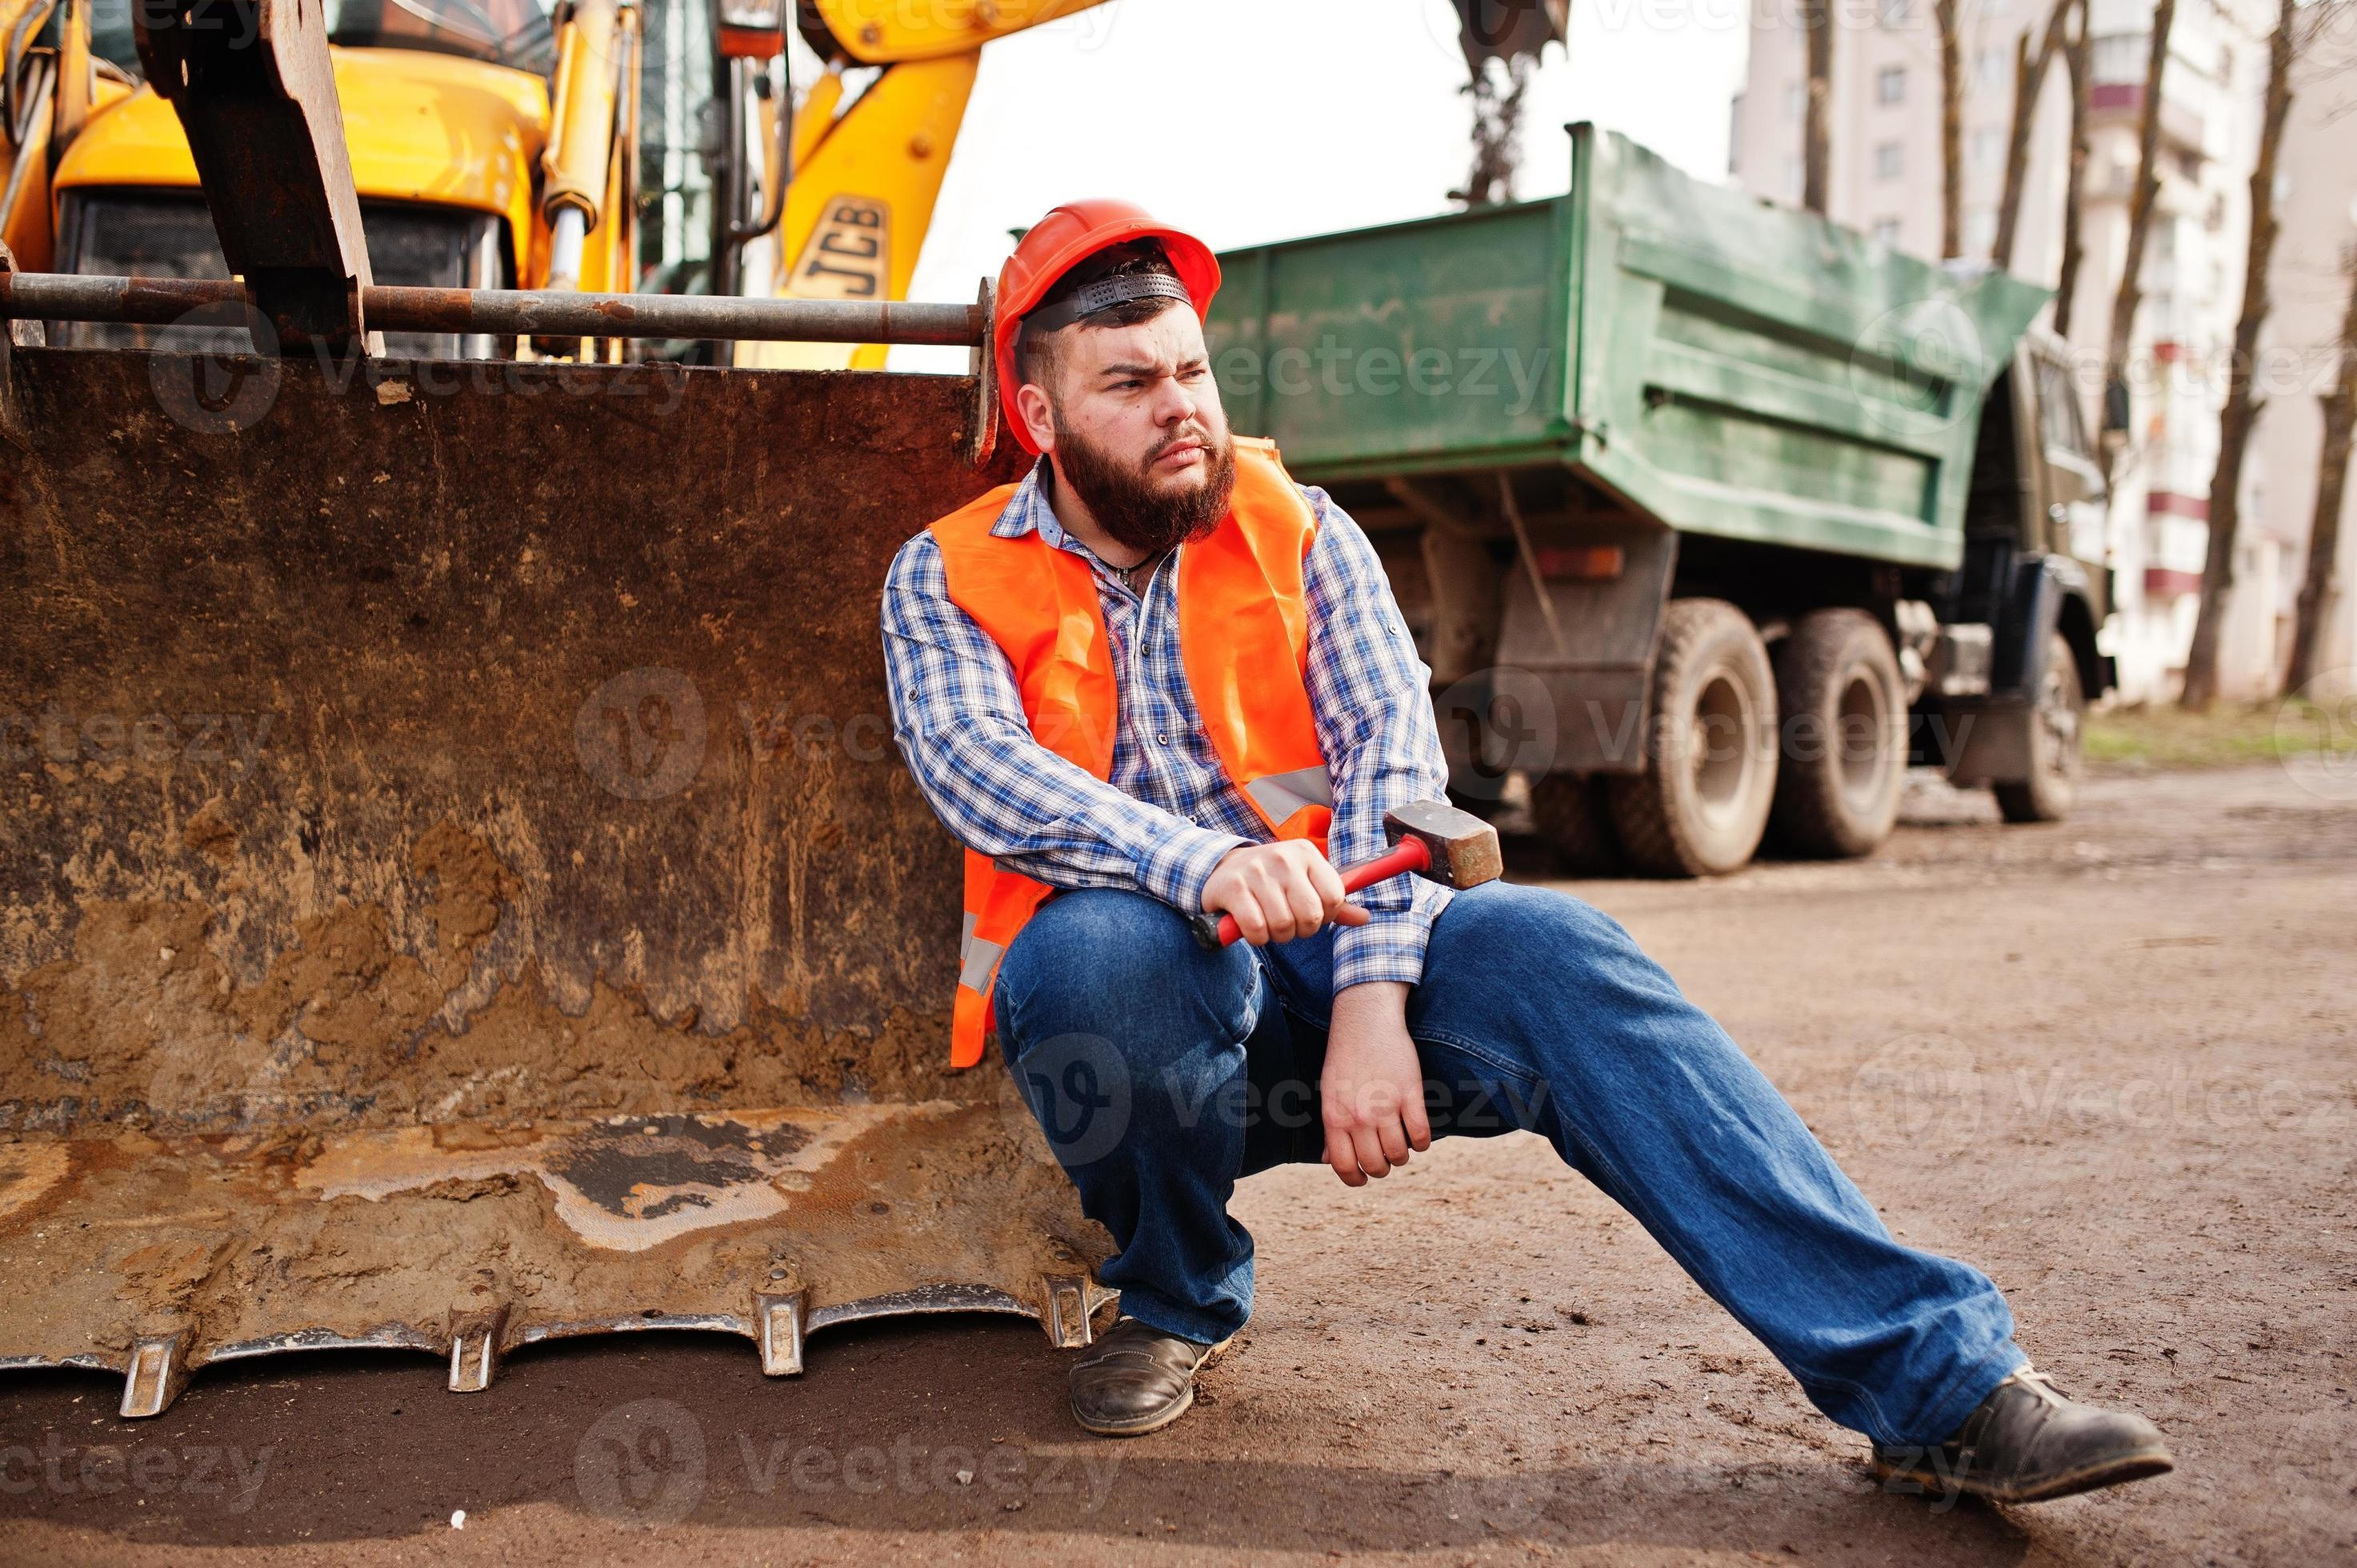

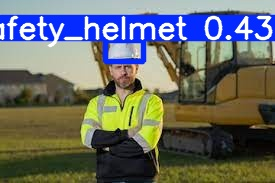

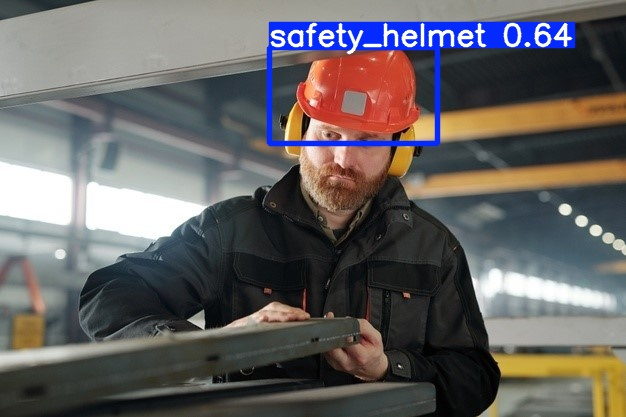

In [27]:
# @title
<script>
  import glob
  from IPython.display import Image, display

  image_paths = glob.glob('yolov5/runs/detect/resultado_60epocas2/*.jpg')

  for path in image_paths:
      display(Image(filename=path))

</script>